<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">
            <tr>
                <td  style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="skyblue">University of Tehran</i></font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
            </tr>
        </table>
    </div>
</div>

## Table of Contents

- [Libraries](#Libraries)

- [Exploring the Dataset and Preprocessing](#Exploring-the-Dataset-and-Preprocessing)

- [Building Model](#Building-Model)

- [Training Model](#Training-Model)

- [Evaluate Model](#Evaluate-Model)

## Mutual Information Analysis of Deep Neural Network Training on CIFAR-10

### Libraries:

In [ ]:
!pip install git+https://github.com/gregversteeg/NPEET.git

  Cloning https://github.com/gregversteeg/NPEET.git to /tmp/pip-req-build-0vp1gzvb
  Running command git clone --filter=blob:none --quiet https://github.com/gregversteeg/NPEET.git /tmp/pip-req-build-0vp1gzvb
  Resolved https://github.com/gregversteeg/NPEET.git to commit 8b0d9485423f74e5eb199324cf362765596538d3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for NPEET: filename=NPEET-1.0.1-py3-none-any.whl size=7348 sha256=c6820195e95853cefca3477b8a5620e8360de5edfc6f728ed434ec610e5a5ba9
  Stored in directory: /tmp/pip-ephem-wheel-cache-yxnr6deg/wheels/b2/f8/20/112d589bf96999032e5053cce7a06c321a9aefaf1be609107a
Successfully built NPEET


In [ ]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from npeet.entropy_estimators import mi
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

### Exploring the Dataset and Preprocessing:

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(f"Training set: {x_train.shape}, {y_train_onehot.shape}")
print(f"Validation set: {x_val.shape}, {y_val_onehot.shape}")
print(f"Test set: {x_test.shape}, {y_test_onehot.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Training set: (50000, 32, 32, 3), (50000, 10)
Validation set: (5000, 32, 32, 3), (5000, 10)
Test set: (5000, 32, 32, 3), (5000, 10)


In [ ]:
train_data_amount = y_train.shape[0]
val_data_amount = y_val.shape[0]
test_data_amount = y_test.shape[0]
total_data_amount = train_data_amount + test_data_amount + val_data_amount

train_percentage = (train_data_amount / total_data_amount) * 100
val_percentage = (val_data_amount / total_data_amount) * 100
test_percentage = (test_data_amount / total_data_amount) * 100

print(f"Training data: {train_percentage:.2f}%")
print(f"Validation data: {val_percentage:.2f}%")
print(f"Testing data: {test_percentage:.2f}%")

Training data: 83.33%
Validation data: 8.33%
Testing data: 8.33%


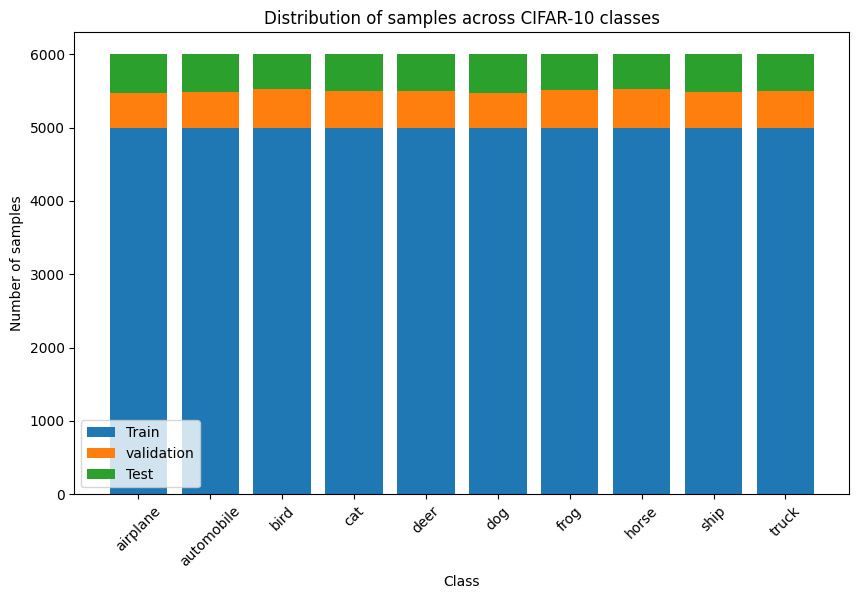

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_counts = np.bincount(y_train.flatten(), minlength=len(class_names))
val_counts = np.bincount(y_val.flatten(), minlength=len(class_names))
test_counts = np.bincount(y_test.flatten(), minlength=len(class_names))

plt.figure(figsize=(10, 6))
plt.bar(class_names, train_counts, label="Train")
plt.bar(class_names, val_counts, bottom=train_counts, label="validation")
plt.bar(class_names, test_counts, bottom=train_counts+val_counts, label="Test")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.title("Distribution of samples across CIFAR-10 classes")
plt.ylabel("Number of samples")
plt.xlabel("Class")
plt.legend()
plt.show()


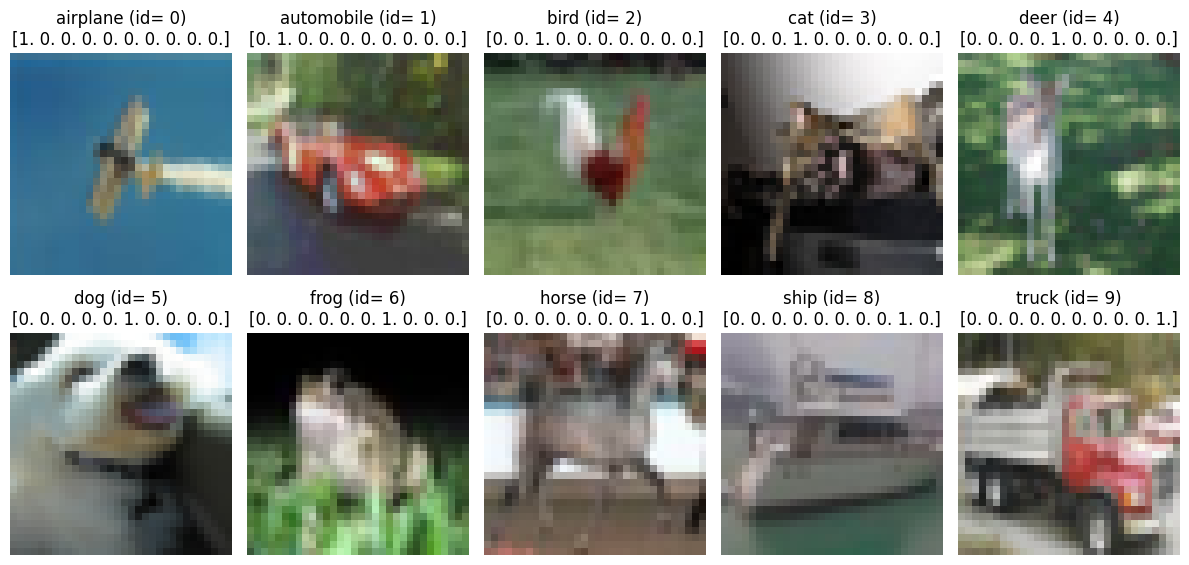

In [ ]:
class_images = {}
class_labels = {}
for class_id, class_name in enumerate(class_names):
    class_indices = np.where(y_train == class_id)[0]
    selected_index = random.choice(class_indices)
    class_images[class_name] = x_train[selected_index]
    class_labels[class_name] = y_train_onehot[selected_index]

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()
for i, class_name in enumerate(class_names):
    axs[i].imshow(class_images[class_name])
    axs[i].set_title(f"{class_name} (id= {i})\n{class_labels[class_name]}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()


### Building Model:

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu', name="dense_1")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu', name="dense_2")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu', name="dense_3")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu', name="dense_4")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(10, activation='softmax', name="output")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,0

 Total params: 860,458 (3.28 MB)

 Trainable params: 858,026 (3.27 MB)

 Non-trainable params: 2,432 (9.50 KB)

### Training Model:

In [ ]:
def estimate_mi_t_y(act, labels):
    labels = labels.ravel()
    mi_neurons = mutual_info_classif(act, labels, discrete_features=False)
    return np.mean(mi_neurons)

def estimate_mi_x_t(X, T):
    return mi(X, T)

layer_names = ["dense_1", "dense_2", "dense_3", "dense_4", "output"]
layer_outputs = [model.get_layer(name).output for name in layer_names]
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

epochs = 50
batch_size = 256
mi_x_t_history = {name: [] for name in layer_names}
mi_t_y_history = {name: [] for name in layer_names}

print("\nEpoch |  Loss  | Accuracy | Avg I(X;T) | Avg I(T;Y)")
print("-" * 52)

for epoch in range(epochs):
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1, verbose=3)

    train_loss = history.history['loss'][0]
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    sample_x = x_train[:1000]  # Shape: (1000, 28, 28)
    sample_y = y_train[:1000].ravel()  # Shape: (1000,)
    sample_x_flat = sample_x.reshape(len(sample_x), -1)  # Shape: (1000, 784)

    activations = activation_model.predict(sample_x, batch_size=256, verbose=0)

    for layer_name, act in zip(layer_names, activations):
        mi_x_t = estimate_mi_x_t(sample_x_flat, act)
        mi_t_y = estimate_mi_t_y(act, sample_y)
        mi_x_t_history[layer_name].append(mi_x_t)
        mi_t_y_history[layer_name].append(mi_t_y)

    print(f"{epoch+1:4d}  | {test_loss:.4f} | {test_acc:.5f}  | {np.mean(list(mi_x_t_history.values())[-1]):.7f}  | {np.mean(list(mi_t_y_history.values())[-1]):.7f}")


Epoch |  Loss  | Accuracy | Avg I(X;T) | Avg I(T;Y)
----------------------------------------------------
   1  | 3.2123 | 0.13540  | 0.0052099  | 0.1630262
   2  | 2.2940 | 0.30280  | 0.0888221  | 0.2161359
   3  | 1.2322 | 0.57460  | 0.1011068  | 0.2676290
   4  | 1.1632 | 0.63060  | 0.0862494  | 0.3100536
   5  | 0.8373 | 0.71260  | 0.0677297  | 0.3481708
   6  | 0.8925 | 0.70160  | 0.0583303  | 0.3707671
   7  | 0.7268 | 0.75680  | 0.0507271  | 0.3899411
   8  | 0.7036 | 0.76120  | 0.0571052  | 0.4031653
   9  | 0.7284 | 0.75760  | 0.0541275  | 0.4122590
  10  | 0.7257 | 0.76040  | 0.0540269  | 0.4204873
  11  | 0.7361 | 0.76180  | 0.0564554  | 0.4269573
  12  | 0.7861 | 0.75260  | 0.0547088  | 0.4351723
  13  | 0.7183 | 0.77460  | 0.0540676  | 0.4410970
  14  | 0.7094 | 0.77780  | 0.0528717  | 0.4473765
  15  | 0.6770 | 0.78880  | 0.0529928  | 0.4535529
  16  | 0.7080 | 0.77860  | 0.0523601  | 0.4582669
  17  | 0.7292 | 0.78180  | 0.0509490  | 0.4660926
  18  | 0.6922 | 0.79420  |

### Evaluate Model:

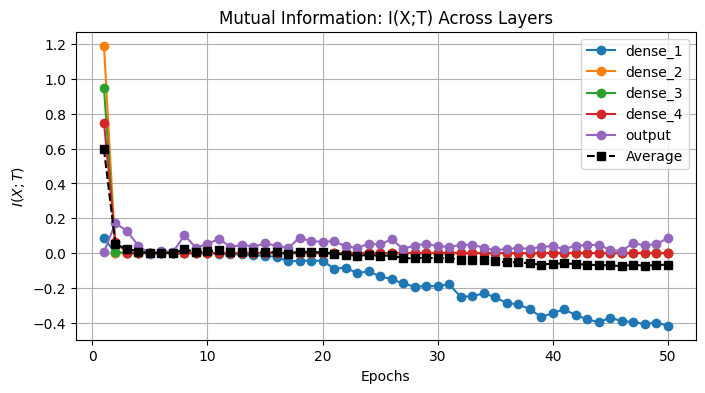

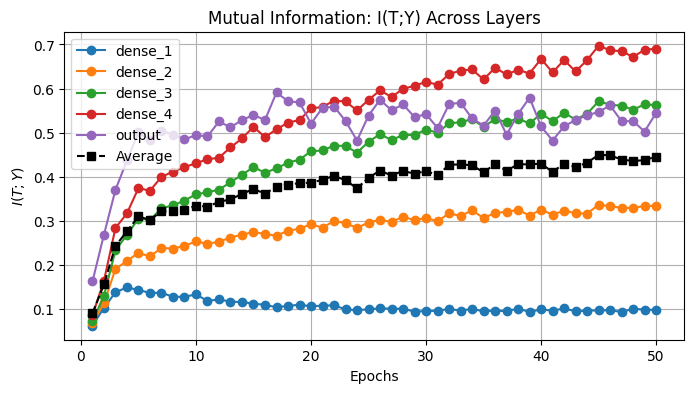

In [ ]:
plt.figure(figsize=(8, 4))
for layer_name in layer_names:
    plt.plot(range(1, epochs+1), mi_x_t_history[layer_name], marker='o', label=f"{layer_name}")

avg_mi_x_t = np.mean([mi_x_t_history[layer] for layer in layer_names], axis=0)
plt.plot(range(1, epochs+1), avg_mi_x_t, marker='s', linestyle='--', color='black', label="Average")

plt.xlabel("Epochs")
plt.ylabel(r"$I(X;T)$")
plt.title("Mutual Information: I(X;T) Across Layers")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
for layer_name in layer_names:
    plt.plot(range(1, epochs+1), mi_t_y_history[layer_name], marker='o', label=f"{layer_name}")

avg_mi_t_y = np.mean([mi_t_y_history[layer] for layer in layer_names], axis=0)
plt.plot(range(1, epochs+1), avg_mi_t_y, marker='s', linestyle='--', color='black', label="Average")

plt.xlabel("Epochs")
plt.ylabel(r"$I(T;Y)$")
plt.title("Mutual Information: I(T;Y) Across Layers")
plt.legend()
plt.grid(True)
plt.show()


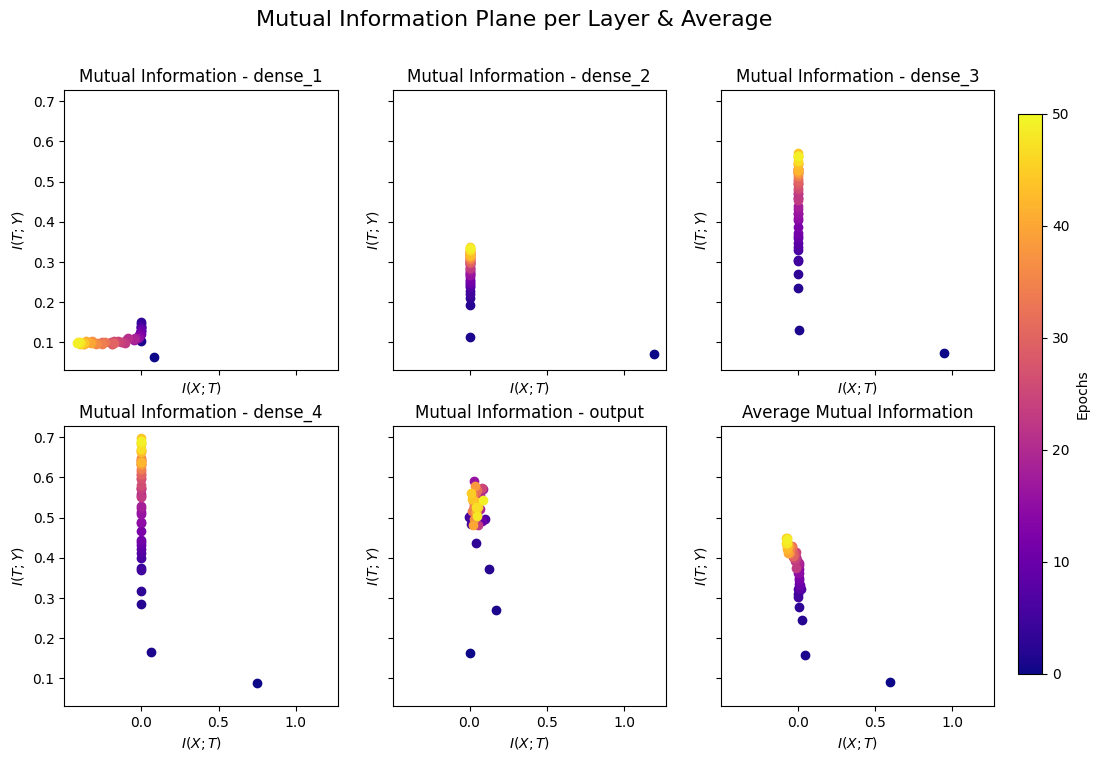

In [ ]:
num_layers = len(layer_names)
rows, cols = 2, 3

fig, axes = plt.subplots(rows, cols, figsize=(12, 8), sharex=True, sharey=True)

axes = axes.flatten()

for idx, layer in enumerate(layer_names):
    ax = axes[idx]

    mi_x_t_vals = mi_x_t_history[layer]
    mi_t_y_vals = mi_t_y_history[layer]

    for epoch in range(epochs):
        scatter = ax.scatter(mi_x_t_vals[epoch], mi_t_y_vals[epoch], c=[epoch], cmap='plasma', vmin=0, vmax=epochs)

    ax.set_xlabel(r"$I(X;T)$")
    ax.set_ylabel(r"$I(T;Y)$")
    ax.set_title(f"Mutual Information - {layer}")

avg_mi_x_t_vals = np.mean([mi_x_t_history[layer] for layer in layer_names], axis=0)
avg_mi_t_y_vals = np.mean([mi_t_y_history[layer] for layer in layer_names], axis=0)

avg_ax = axes[num_layers]
for epoch in range(epochs):
    avg_ax.scatter(avg_mi_x_t_vals[epoch], avg_mi_t_y_vals[epoch], c=[epoch], cmap='plasma', vmin=0, vmax=epochs)

avg_ax.set_xlabel(r"$I(X;T)$")
avg_ax.set_ylabel(r"$I(T;Y)$")
avg_ax.set_title("Average Mutual Information")

for idx in range(num_layers + 1, len(axes)):
    fig.delaxes(axes[idx])

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(scatter, cax=cbar_ax, label="Epochs")

plt.suptitle("Mutual Information Plane per Layer & Average", fontsize=16)
# plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
